# Naive Bayes Model: Google Play Store Reviews 
## 1. Import Modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

## 2. Data Preparation 
### 2.1 Data download from CSV file 

In [2]:
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 2.2 Data Inspection 

In [5]:
data_df.head().T

,0,1,2,3,4
package_name,com.facebook.katana,com.facebook.katana,com.facebook.katana,com.facebook.katana,com.facebook.katana
review,privacy at least put some option appear offli...,"messenger issues ever since the last update, ...",profile any time my wife or anybody has more ...,the new features suck for those of us who don...,forced reload on uploading pic on replying co...
polarity,0,0,0,0,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


### 2.3 Train-test split 

In [7]:
training_df, testing_df=train_test_split(data_df, test_size=0.3, random_state=315)

In [8]:
training_df.head().T

,106,4,589,712,592
package_name,com.linkedin.android,com.facebook.katana,com.evernote,com.opera.mini.native,com.evernote
review,why can't i share my achievements? recently d...,forced reload on uploading pic on replying co...,very user friendly! for those looking for a s...,save image and low performance can not save a...,too much going on its cool it works but ony u...
polarity,0,0,1,0,1


### 2.4 Data Encoding 

In [9]:
training_reviews=training_df['review']
testing_reviews=testing_df['review']
training_reviews.head()

106     why can't i share my achievements? recently d...
4       forced reload on uploading pic on replying co...
589     very user friendly! for those looking for a s...
712     save image and low performance can not save a...
592     too much going on its cool it works but ony u...
Name: review, dtype: object

In [10]:
training_reviews.info()

<class 'pandas.core.series.Series'>
Index: 623 entries, 106 to 873
Series name: review
Non-Null Count  Dtype 
--------------  ----- 
623 non-null    object
dtypes: object(1)
memory usage: 9.7+ KB


In [11]:
testing_reviews.info()

<class 'pandas.core.series.Series'>
Index: 268 entries, 393 to 699
Series name: review
Non-Null Count  Dtype 
--------------  ----- 
268 non-null    object
dtypes: object(1)
memory usage: 4.2+ KB


In [12]:
vector_model=CountVectorizer(stop_words="english")
vector_model.fit(training_reviews)
training_word_counts=vector_model.transform(training_reviews).toarray()
testing_word_counts=vector_model.transform(testing_reviews).toarray()

print(f'Word count matrix has {training_word_counts.shape[0]} rows and {training_word_counts.shape[1]} columns')

Word count matrix has 623 rows and 3012 columns


In [13]:
training_word_counts[0]


array([0, 0, 0, ..., 0, 0, 0], shape=(3012,))

In [14]:
feature_names=vector_model.get_feature_names_out()
training_word_counts=pd.DataFrame(training_word_counts, columns=feature_names)
testing_word_counts=pd.DataFrame(testing_word_counts, columns=feature_names)
training_word_counts.head().T

,0,1,2,3,4
000,0,0,0,0,0
04,0,0,0,0,0
0x,0,0,0,0,0
10,0,0,0,0,0
100,0,0,0,0,0
...,...,...,...,...,...
żŕ,0,0,0,0,0
żŕľ,0,0,0,0,0
žŕ,0,0,0,0,0
žŕľ,0,0,0,0,0


## 3. EDA 
### 3.1. Baseline model performance 

In [15]:
training_df['polarity'].value_counts()

polarity
0    414
1    209
Name: count, dtype: int64

In [16]:
testing_df['polarity'].value_counts()

polarity
0    170
1     98
Name: count, dtype: int64

In [17]:
training_df['package_name'].value_counts()

package_name
com.evernote                  32
com.Slack                     32
org.mozilla.firefox           31
com.facebook.orca             30
com.android.chrome            30
com.facebook.katana           30
com.hamropatro                29
com.dropbox.android           29
com.king.candycrushsaga       28
com.supercell.clashofclans    28
com.tencent.mm                28
com.google.android.talk       27
com.viber.voip                27
com.hamrokeyboard             27
com.linkedin.android          26
com.imangi.templerun2         26
com.opera.mini.native         26
com.shirantech.kantipur       26
com.rovio.angrybirds          25
com.twitter.android           24
com.whatsapp                  24
com.uc.browser.en             21
jabanaki.todo.todoly          17
Name: count, dtype: int64

Accuracy of a constant '0' model 

In [18]:
accuracy=((len(testing_df) - sum(testing_df['polarity'])) / len(testing_df))*100
print(f'Testing accuracy of constant "0" polarity model: {accuracy:.2f}%')

Testing accuracy of constant "0" polarity model: 63.43%


Logistic Regression Model 

In [19]:
model=LogisticRegression()
model.fit(training_word_counts, training_df['polarity'])

accuracy=accuracy_score(model.predict(testing_word_counts),testing_df['polarity'])

print(f'Testing accuracy of logistic regression model: {accuracy*100:.1f}%')

Testing accuracy of logistic regression model: 78.4%


In [23]:
lengths=training_df['review'].str.len().tolist()
print(lengths)

[160, 466, 209, 151, 488, 228, 210, 307, 208, 477, 209, 200, 457, 463, 111, 212, 123, 130, 378, 364, 115, 181, 262, 333, 212, 220, 370, 149, 344, 43, 233, 289, 38, 160, 154, 34, 174, 110, 380, 242, 217, 184, 228, 275, 230, 237, 168, 21, 147, 429, 198, 292, 358, 395, 150, 42, 261, 302, 273, 141, 510, 165, 79, 366, 168, 198, 141, 366, 156, 288, 8, 374, 56, 423, 233, 268, 111, 148, 129, 106, 35, 195, 106, 185, 176, 286, 325, 175, 15, 125, 196, 181, 106, 164, 265, 531, 287, 81, 192, 158, 233, 53, 216, 86, 145, 167, 222, 220, 236, 389, 282, 138, 440, 198, 249, 201, 258, 161, 198, 168, 136, 209, 116, 163, 212, 342, 152, 274, 516, 160, 156, 162, 331, 224, 79, 142, 419, 115, 192, 115, 126, 443, 118, 175, 253, 314, 46, 190, 177, 257, 197, 444, 286, 404, 287, 459, 205, 217, 242, 273, 218, 219, 222, 210, 282, 465, 163, 341, 83, 157, 160, 231, 402, 500, 26, 151, 225, 155, 135, 151, 223, 133, 386, 347, 173, 202, 184, 133, 253, 269, 25, 159, 308, 53, 510, 525, 71, 211, 217, 171, 483, 535, 281, 196, 

### 3.2 Review Length Distributions 

Mean of Review length: 227
Min count of Review length: 8
Max count of Review length: 910


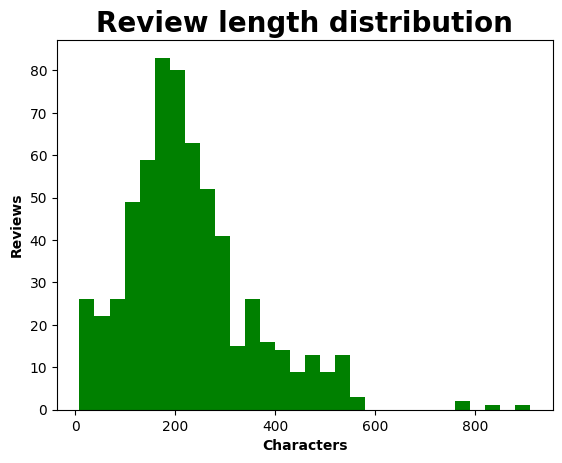

In [30]:
lengths=training_df['review'].str.len().tolist()
print(f'Mean of Review length: {np.mean(lengths):.0f}')
print(f'Min count of Review length: {min(lengths):.0f}')
print(f'Max count of Review length: {max(lengths):.0f}')

plt.title('Review length distribution', fontsize=20, fontweight='bold')
plt.xlabel('Characters', fontweight='bold')
plt.ylabel('Reviews', fontweight='bold')
plt.hist(lengths, bins=30, color='green')
plt.show()

